In [40]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
seed_value = 1
os.environ['PYTHONHASHSEED']=str(seed_value)
def reset_random_seeds():
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
reset_random_seeds()

In [41]:
!pip3 install transformers

In [42]:
train_data = pd.read_csv("train.csv")
train_data.head()


,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [43]:
train_data.isnull().sum()

Text_ID                0
Product_Description    0
Product_Type           0
Sentiment              0
dtype: int64

2    3765
3    2089
1     399
0     111
Name: Sentiment, dtype: int64


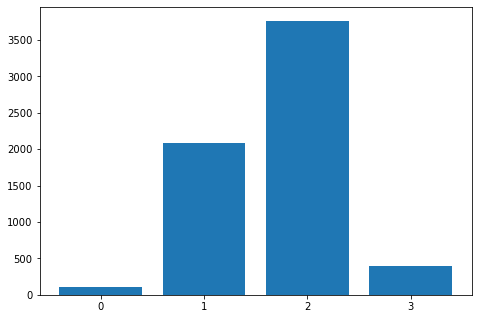

In [44]:
tempdf = train_data["Sentiment"].value_counts()
print(tempdf)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pd.unique(train_data["Sentiment"]), train_data["Sentiment"].value_counts())
ax.set_xticks(pd.unique(train_data["Sentiment"]))
plt.show()

9    4070
6     665
2     465
7     327
3     300
5     213
8     194
1      59
0      52
4      19
Name: Product_Type, dtype: int64


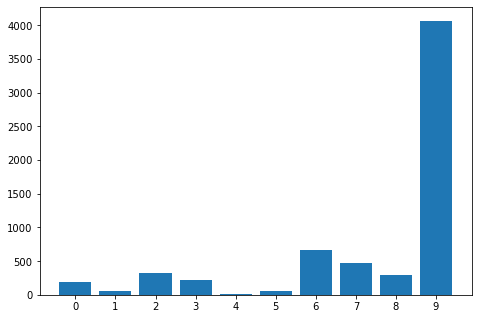

In [45]:

tempdf = train_data["Product_Type"].value_counts()
print(tempdf)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pd.unique(train_data["Product_Type"]), train_data["Product_Type"].value_counts())
ax.set_xticks(pd.unique(train_data["Product_Type"]))
plt.show()

In [46]:
import re, string, six

def clean_text(s):
    try:
        return re.sub(r'[^A-Za-z0-9,?"\'. ]+', '', s).encode('utf-8').decode('utf-8').lower()
    except:
        return ""

train_data['Product_Description'] = train_data['Product_Description'].apply(lambda x: clean_text(x))
print(train_data['Product_Description'])

0       the web designers guide to ios and android app...
1       rt mention line for ipad 2 is longer today tha...
2       crazy that apple is opening a temporary store ...
3       the lesson from google one pass in this digita...
4       rt mention at the panel quotyour mom has an ip...
                              ...                        
6359    thanks mention for hosting this event sxsw sxs...
6360    sxsw iphone app is awesome, but ipad app crash...
6361    rt mention rt mention download 20 free tracks ...
6362    oh at texas social media awards 'you don't nee...
6363    google launching a quotmajorquot new social ne...
Name: Product_Description, Length: 6364, dtype: object


In [47]:
from numpy.ma.core import shape
from sklearn.model_selection import train_test_split

X = train_data["Product_Description"]
y = train_data["Sentiment"]

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=23)
X_test, X_val, y_test, y_val =train_test_split(X_test, y_test, test_size=0.5, random_state=23)
# Shape of Train data
print(shape(X_train))

# Shape of Validation data
print(shape(X_val))

# Shape of Test data
print(shape(X_test))

(5091,)
(637,)
(636,)


In [48]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, cv=kf)

    return auc.mean()

In [50]:
from sklearn.metrics import accuracy_score, roc_curve, auc
def AUCplot(predicted_yval, y_val, prob_predicted_yval):
  preds = prob_predicted_yval[:, 1]
  fpr, tpr, threshold = roc_curve(y_val, preds, pos_label=1)
  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc:.4f}')
       
  #   # Get accuracy over the test set
  #y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_val, predicted_yval)
  print(f'Accuracy: {accuracy*100:.2f}%')
    
  #   # Plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()



2
[2.72351937e-04 2.26834481e-03 7.87410997e-01 2.10048306e-01]
AUC: 0.7230
Accuracy: 61.85%


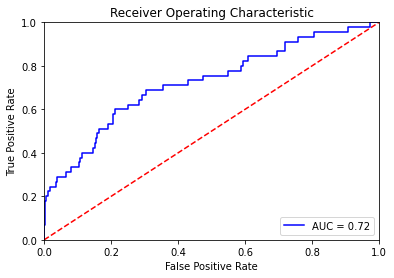

In [51]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1)

model.fit(X_train_tfidf, y_train)
prob_predicted_yval = model.predict_proba(X_val_tfidf)
predicted_yval = model.predict(X_val_tfidf)
print(predicted_yval[0])
print(prob_predicted_yval[0])
AUCplot(predicted_yval, y_val, prob_predicted_yval)

In [52]:
model.score(X_val_tfidf, y_val)

0.6185243328100472

In [53]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case = True)


In [54]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

encoded_data_train = tokenizer.batch_encode_plus(
    [text for text in X_train], 
    add_special_tokens=True, 
    return_attention_mask=True,
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    [text for text in X_val], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor([text for text in y_train])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor([text for text in y_val])

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\rakes\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [65]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

train_dataloader = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

val_dataloader = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [66]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [67]:

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.182025   |     -      |     -     |   76.07  


In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    [text for text in X_test], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor([text for text in y_test])

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=4,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

# model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

test, predictions, true_test = evaluate(dataloader_test)
accuracy_per_class(predictions, true_test)






In [ ]:
probs = bert_predict(model, dataloader_test)

In [ ]:
evaluate_roc(predictions, true_test, probs)